# Restaurant reviews classification model  

<font size=2> classifying as positive review or negative opinion <br>classic bag of words method, Naive Bayes model

## Importing libraries

In [1]:
# general libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Preparing the text data
import re 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
# Splitting the dataset
from sklearn.model_selection import train_test_split
# Training the classification models
from sklearn.naive_bayes import GaussianNB # Naive Bayes
from sklearn.linear_model import LogisticRegression # Logistic Regression
from sklearn.tree import DecisionTreeClassifier # Decision tree
from sklearn.ensemble import RandomForestClassifier # Random forest
from sklearn.svm import SVC # SVM and Kernel SVM
from sklearn.neighbors import KNeighborsClassifier # K-nearest neighbours
# Model evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, precision_score, roc_auc_score, roc_curve

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Michał\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Importing dataset

In [2]:
# 1 - liked
# 0 - not liked

In [3]:
dataset = pd.read_csv('Restaurant_Reviews.tsv', delimiter = '\t', quoting = 3)

In [4]:
dataset.head(3)

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0


## Preparing the text

In [5]:
corpus = []
for i in range(0, dataset.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', dataset['Review'][i]) # replace non-letters (comma, dot, etc.) with a space
    review = review.lower() # transform to lower letters
    review = review.split() # splitting the sentence into words
    ps = PorterStemmer() 
    all_stopwords = stopwords.words('english') # Stopwords are words like 'a', 'an', 'the', etc. Stopwords are not relevant in NLP process and are not included in the next parts of NLP. 
    all_stopwords.remove('not') # do not include word 'not' in stopwords - actually, it is an important word
    review = [ps.stem(word) for word in review if not word in set(all_stopwords)] # stimming the words, trimming the words which are not english stopwords. 
    review = ' '.join(review)
    corpus.append(review)


## Creating the Bag of Words model

In [6]:
# tokenization
cv = CountVectorizer(max_features = 1500) # taking only most frequent words
X = cv.fit_transform(corpus).toarray() # matrix of features
y = dataset.iloc[:,-1].values

## Spliting the dataset into Training set and Test set

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)

## Training different classification models

### Naive Bayes

In [8]:
classifier_NB = GaussianNB()
classifier_NB.fit(X_train, y_train)

GaussianNB()

### Logistic regression

In [9]:
classifier_lg = LogisticRegression(random_state = 0)
classifier_lg.fit(X_train, y_train)

LogisticRegression(random_state=0)

### Decision tree

In [10]:
classifier_tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier_tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

### Random forest

In [11]:
classifier_forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier_forest.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

### Support Vector Machine

In [12]:
classifier_svm = SVC(kernel = 'linear', random_state = 0)
classifier_svm.fit(X_train, y_train)

SVC(kernel='linear', random_state=0)

### Kernel Support Vector Machine

In [13]:
classifier_ksvm = SVC(kernel = 'rbf', random_state = 0)
classifier_ksvm.fit(X_train, y_train)

SVC(random_state=0)

### K-nearest neighbours

In [14]:
classifier_knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier_knn.fit(X_train, y_train)

KNeighborsClassifier()

## Models evaluation

Accuracy score and confusion matrix

In [15]:
models = {'Naive Bayes' : classifier_NB, 'Logistic Regression' : classifier_lg, "Decision tree": classifier_tree, "Random forest":classifier_forest, "SVM" : classifier_svm,
         "KSVM" : classifier_ksvm, "K-nearest neighbours": classifier_knn}

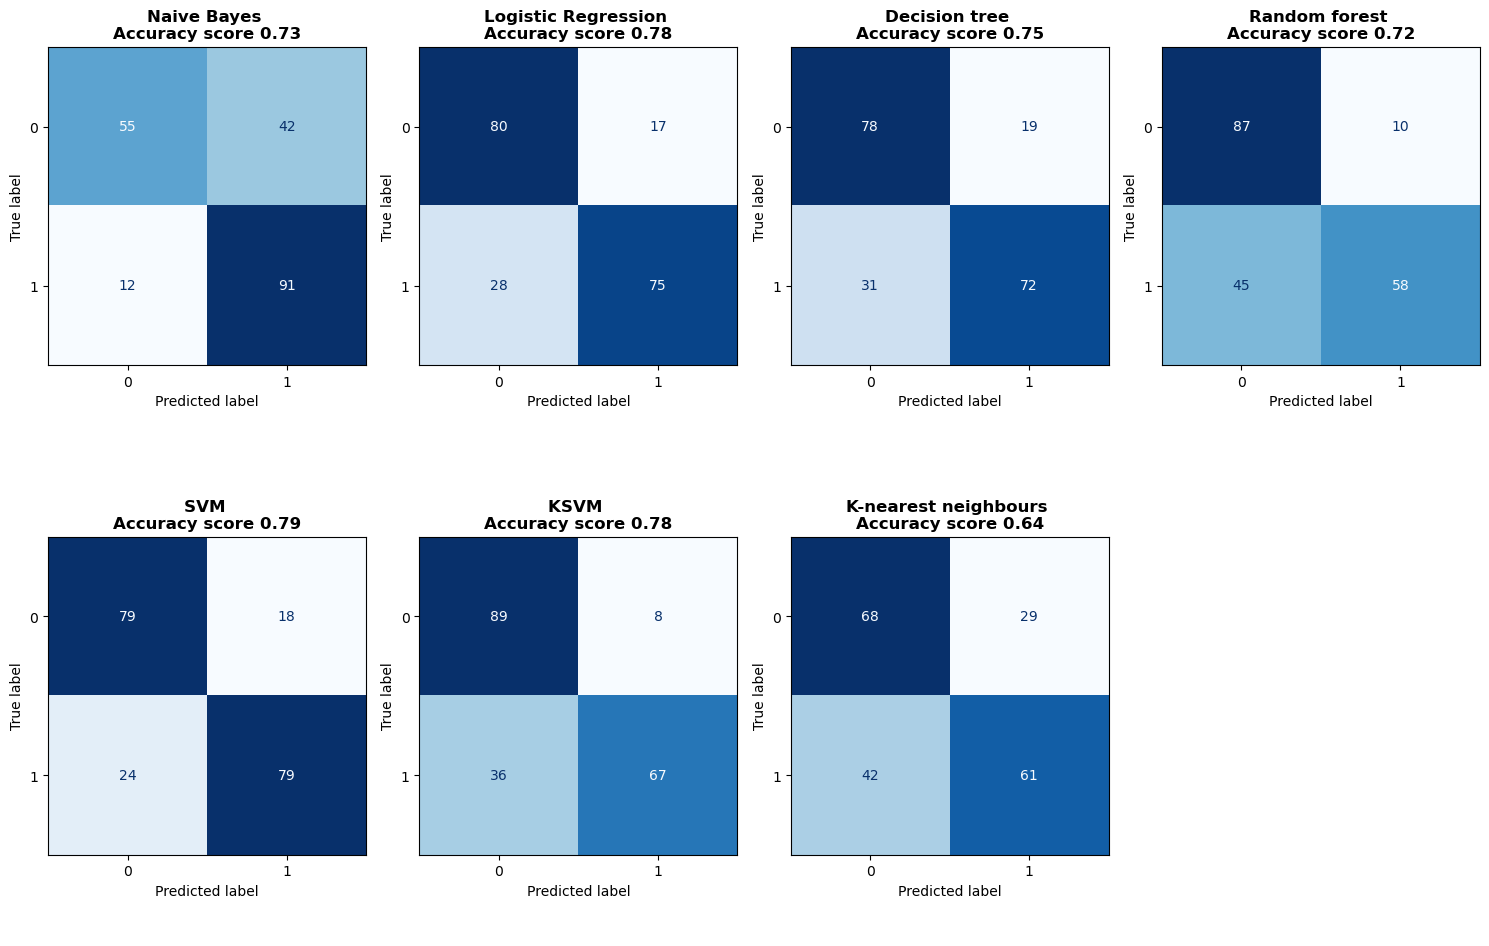

In [16]:
fig, axes = plt.subplots(2, 4, figsize=(15, 10))
axes = axes.flatten()
n = 0
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax = axes[n], cmap = plt.cm.Blues, colorbar = False)
    axes[n].set_title(f'{name} \nAccuracy score {round(accuracy_score(y_test, y_pred),2)}', weight = 'bold')
    n+=1
axes[7].axis('off')
plt.tight_layout()
plt.show()

The choice of model based on the values of the confusion matrix strictly depends on the purpose of the model and our approach to risk. 
<br>In this study, it was decided to choose a model based on <b>Kernel SVM</b>, because the small risk associated with incorrectly predicting a positive opinion was important. Therefore the final model can be considered as conservative (with great caution when classifying opinions as positive).

In [17]:
y_pred = classifier_ksvm.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

In [18]:
false_positive = cm[0, 1]
error_type_1 = false_positive / np.sum(cm[0])
print(f"The probability that a negative review will be classified as positive equals to {round(error_type_1,4)*100}% (Type I error)" )

The probability that a negative review will be classified as positive equals to 8.25% (Type I error)


In [19]:
print(f"{round(precision_score(y_test, y_pred),4)*100}% of reviews classified as positive are actually positive (precision of a model)")

89.33% of reviews classified as positive are actually positive (precision of a model)


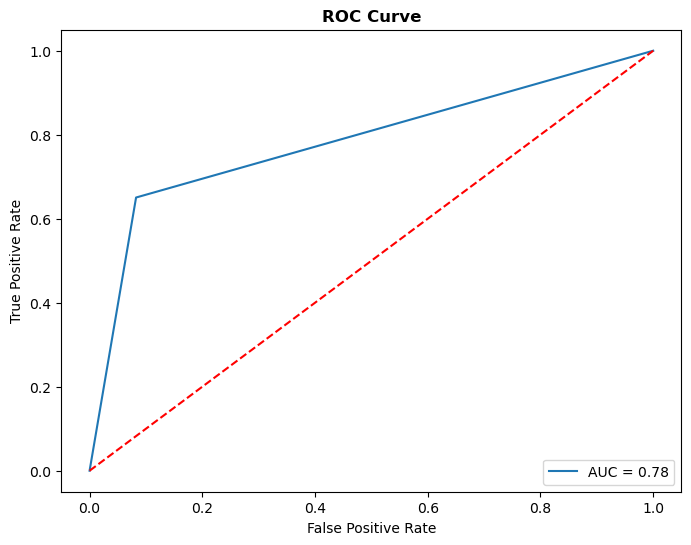

In [22]:
# ROC curve
auc_roc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# Draw of ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_roc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', weight='bold')
plt.legend(loc='lower right')
plt.show()

In general, an AUC score of 1 indicates a perfect classifier and 0.5 indicates a worthless classifier. 
<br> In this case, our model is <b>moderate, prone to misclassifying positive reviews as negative.

<br>
<br>
<b>Finally, the model result are as follows:</b>
<br><b>78%</b> of correct predictions
<br><b>89</b> correct predicitions of negative reviews
<br><b>67</b> correct predicitions of positive reviews
<br><b>8</b> incorrect predicitions of negative reviews
<br><b>36</b> incorrect predicitions of positive reviews
<br> The probability that a negative review will be classified as positive equals to <b>8.25%</b> (Type I error)
<br> <b>89.33%</b> of reviews classified as positive are actually positive (precision of a model)
<br> Model is <b>pretty good, but prone to misclassifying positive reviews as negative.

## Try me!

Model classification based on your own review. Just enter your review in "new_review" string variable located in a cell below and run it!

In [21]:
new_review = 'I am a big fan of this restaurant' # your own review
new_review = re.sub('[^a-zA-Z]', ' ', new_review)
new_review = new_review.lower()
new_review = new_review.split()
ps = PorterStemmer()
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')
new_review = [ps.stem(word) for word in new_review if not word in set(all_stopwords)]
new_review = ' '.join(new_review)
new_corpus = [new_review]
new_X_test = cv.transform(new_corpus).toarray()
new_y_pred = classifier_ksvm.predict(new_X_test)
if new_y_pred == 1:
    print('Positive review')
else:
    print('Negative review')

Positive review
